## Classifying celestial objects with ML

### Importing libraries

In [1]:
!pip install fsspec -q
!pip install s3fs -q
!pip install xgboost -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

### EDA

In [3]:
df = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [5]:
df.describe(include='all')

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000,10000.000000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4998,NaN,NaN,NaN,NaN
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,NaN,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,NaN,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,NaN,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,NaN,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,NaN,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,NaN,0.092579,2559.000000,54468.000000,510.000000


#### Object identity and position
- objid = Object Identifier --> same value column REMOVE
- ra = J2000 Right Ascension (r-band)
- dec = J2000 Declination (r-band)

#### Filters
- u = better of DeV/Exp magnitude fit
- g = better of DeV/Exp magnitude fit
- r = better of DeV/Exp magnitude fit
- i = better of DeV/Exp magnitude fit
- z = better of DeV/Exp magnitude fit

#### Acquisition metadata
- run = Run Number --> maybe
- rereun = Rerun Number --> REMOVE
- camcol = Camera column --> maybe
- field = Field number --> maybe

#### Object info
- specobjid = Object Identifier --> to remove
- class = object class (galaxy, star or quasar object) --> TARGET
- redshift = Final Redshift --> maybe
- plate = plate number --> maybe
- mjd = MJD of observation --> maybe
- fiberid = fiber ID --> maybe

In [6]:
df_clean = df.drop(['objid','specobjid','fiberid','mjd','plate', 'rerun', 'run', 'r', 'i', 'z'], axis=1)

In [7]:
df_clean

,ra,dec,u,g,camcol,field,class,redshift
0,183.531326,0.089693,19.47406,17.04240,4,267,STAR,-0.000009
1,183.598370,0.135285,18.66280,17.21449,4,267,STAR,-0.000055
2,183.680207,0.126185,19.38298,18.19169,4,268,GALAXY,0.123111
3,183.870529,0.049911,17.76536,16.60272,4,269,STAR,-0.000111
4,183.883288,0.102557,17.55025,16.26342,4,269,STAR,0.000590
...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,3,161,GALAXY,0.027583
9996,131.306083,51.671341,18.27255,17.43849,3,162,GALAXY,0.117772
9997,131.552562,51.666986,18.75818,17.77784,3,162,STAR,-0.000402
9998,131.477151,51.753068,18.88287,17.91068,3,163,GALAXY,0.014019


<AxesSubplot:>

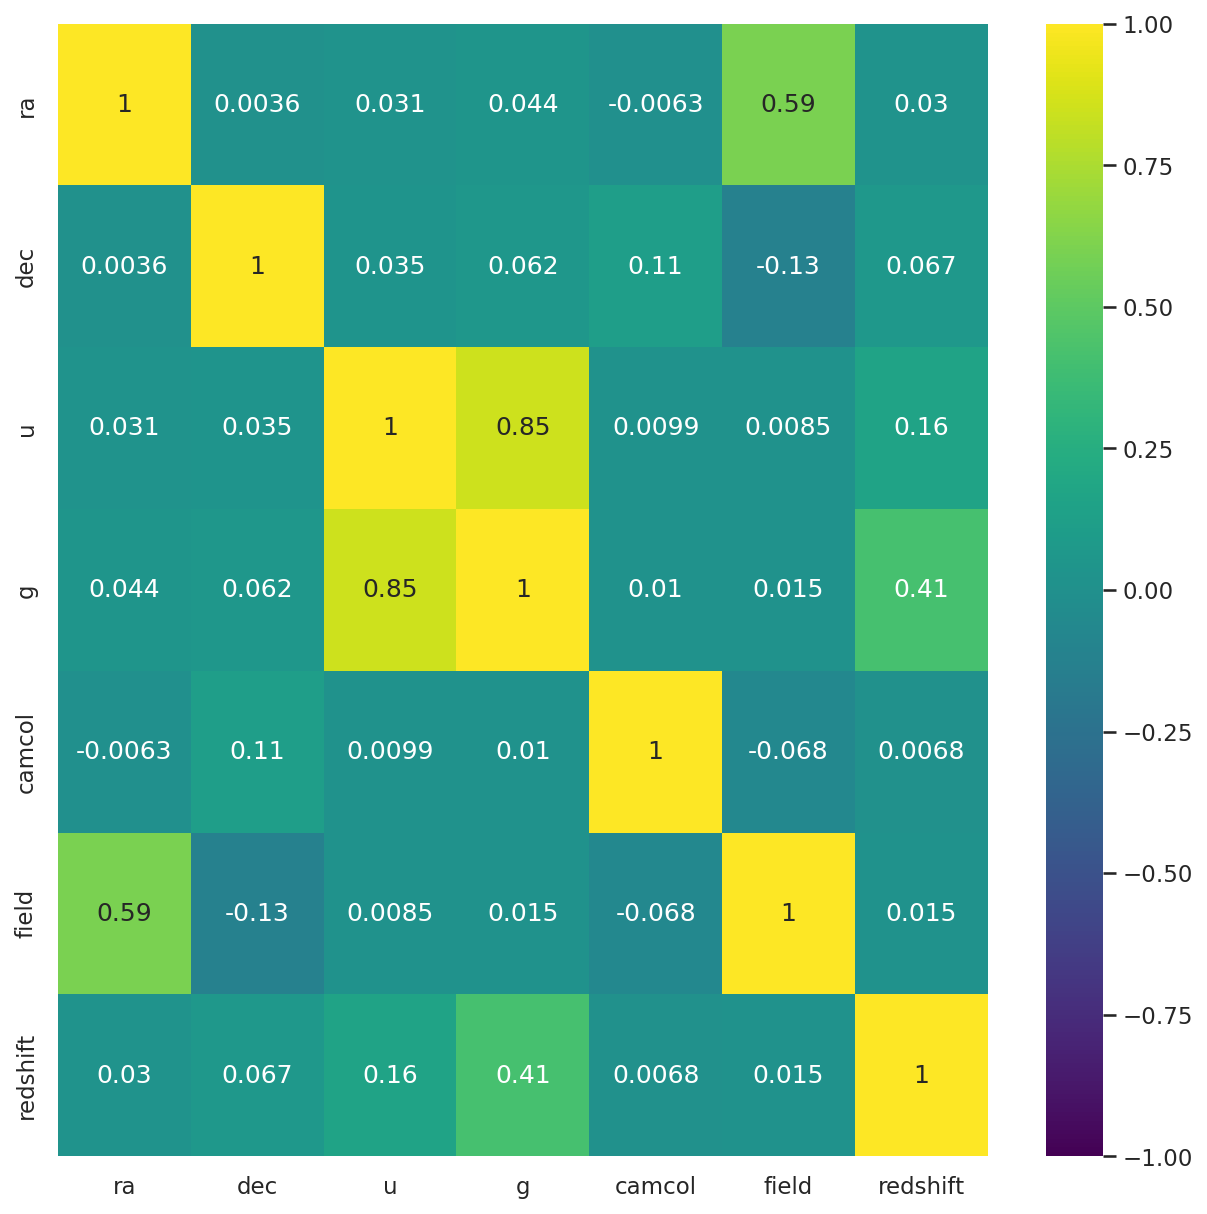

In [8]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_clean.corr(), vmin=-1, vmax=1, annot=True, cmap='viridis')

Dropping the r, i, z color channels to improve the performance of the machine

In [ ]:
df_clean = df_clean.drop([ 'r', 'i', 'z'], axis=1)

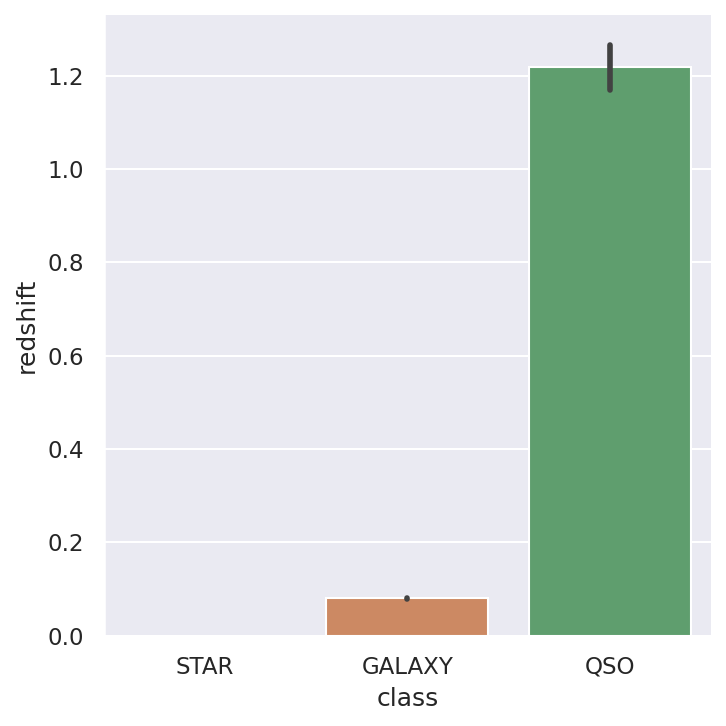

In [9]:
sns.catplot(data= df_clean, x='class' , y='redshift', kind='bar' )

<AxesSubplot:xlabel='ra', ylabel='redshift'>

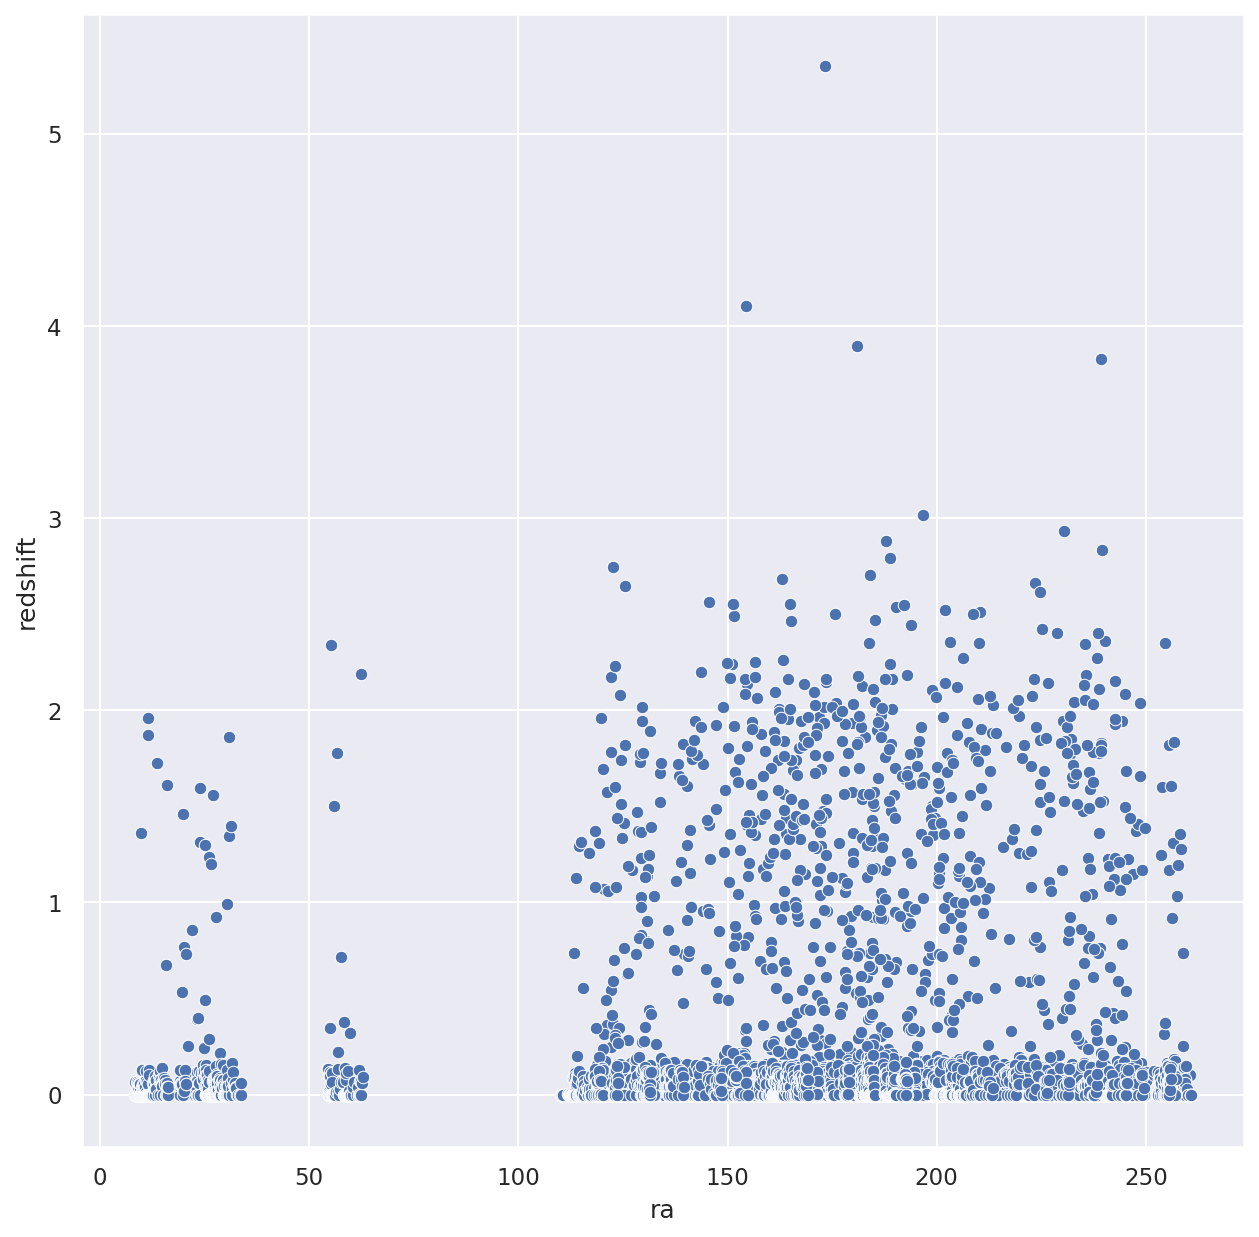

In [10]:
sns.scatterplot(data=df_clean, x='ra' , y='redshift')

### Preprocessing

In [11]:
df_clean['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [12]:
target = 'class'
features_list = ['ra', 'dec', 'u', 'g', 'camcol', 'field', 'redshift']
X = df_clean.loc[:, features_list]
y = df_clean.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [13]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train[:5]

array([0, 0, 2, 0, 2])

### Training 

In [16]:
classifier = XGBClassifier(max_depth=3)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [17]:
y_test_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

In [18]:
print("score on train set : ", classifier.score(X_train, y_train))
print("score on test set : ", classifier.score(X_test, y_test))

score on train set :  0.9984444444444445
score on test set :  0.99


In [19]:
print("f1-score on train set : ", f1_score(y_train, y_train_pred, average='micro'))
print("f1-score on test set : ", f1_score(y_test, y_test_pred, average='micro'))

f1-score on train set :  0.9984444444444445
f1-score on test set :  0.99


In [20]:
print("accuracy on train set : ", precision_score(y_train, y_train_pred,average='micro'))
print("accuracy on test set : ", precision_score(y_test, y_test_pred,average='micro'))

accuracy on train set :  0.9984444444444445
accuracy on test set :  0.99


In [21]:
print("recall-score on train set : ", recall_score(y_train, y_train_pred,average='micro'))
print("recall-score on test set : ", recall_score(y_test, y_test_pred,average='micro'))

accuracy on train set :  0.9984444444444445
accuracy on test set :  0.99


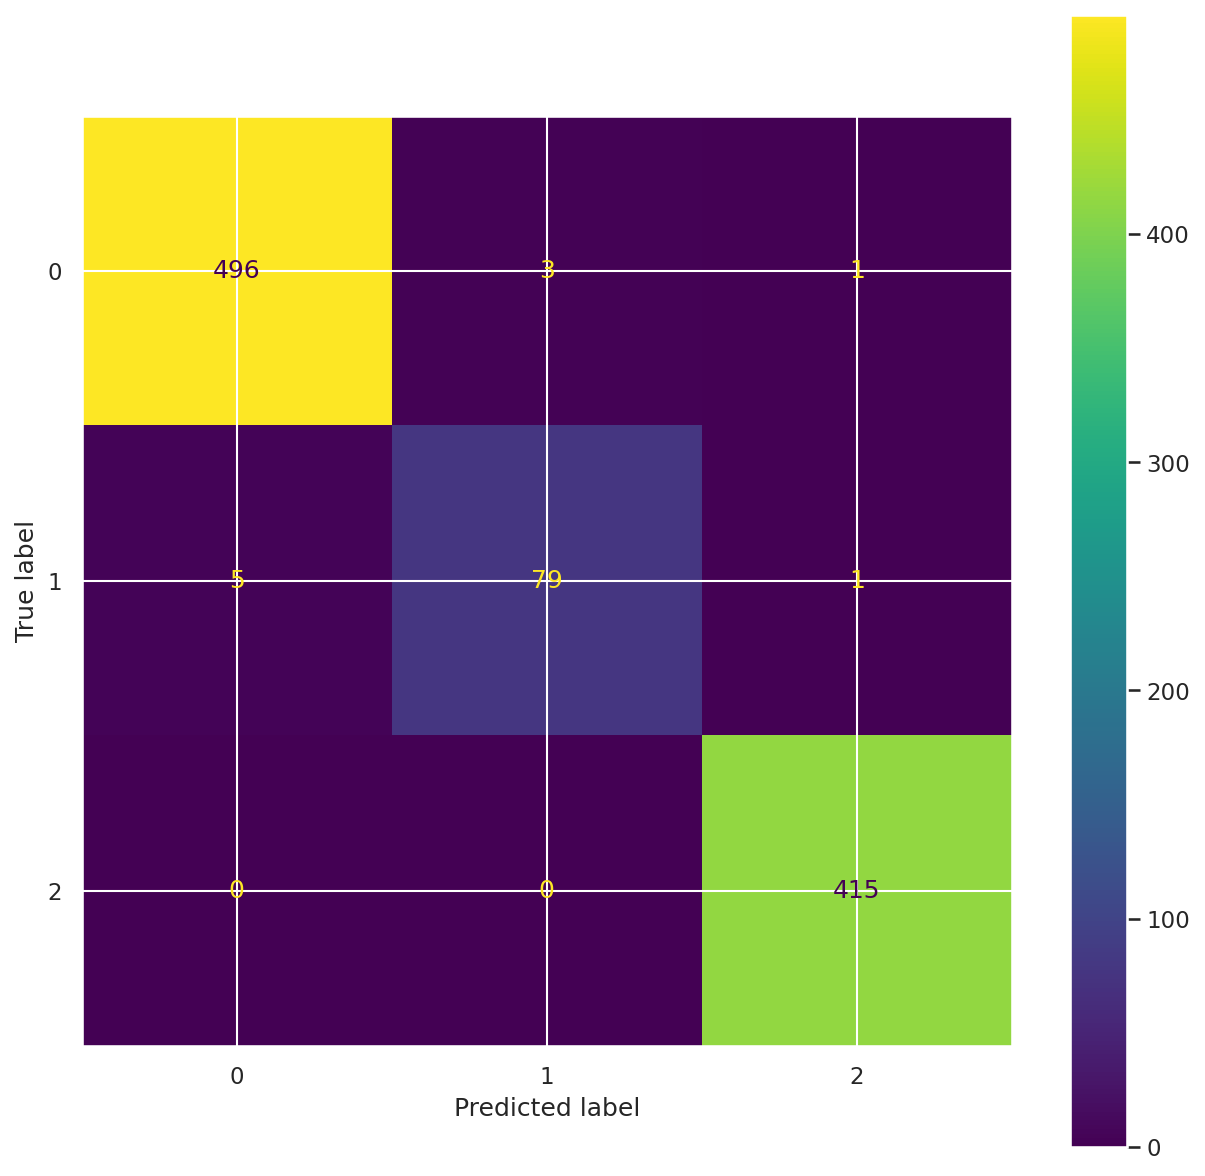

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [23]:
print(cm)

[[496   3   1]
 [  5  79   1]
 [  0   0 415]]


### Optimizing

In [24]:
xgb = XGBClassifier()
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'max_depth': [3, 4, 6, 8],
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.1, 0.01, 0.05]
}

xgb_grid = GridSearchCV(xgb, param_grid = params, verbose = 2) 
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   2.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   2.0s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   2.0s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   2.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.9s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   4.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   3.9s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   3.5s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

In [25]:
xgb_grid.best_params_

{'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100}

```
{'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100}
```

In [26]:
y_test_pred_grid = classifier.predict(X_test)
y_train_pred_grid = classifier.predict(X_train)

In [27]:
print("score on train set : ", xgb_grid.score(X_train, y_train))
print("score on test set : ", xgb_grid.score(X_test, y_test))

score on train set :  0.9954444444444445
score on test set :  0.989


In [28]:
print("f1-score on train set : ", f1_score(y_train, y_train_pred_grid, average='micro'))
print("f1-score on test set : ", f1_score(y_test, y_test_pred_grid, average='micro'))

f1-score on train set :  0.9984444444444445
f1-score on test set :  0.99


In [29]:
print("recall-score on train set : ", recall_score(y_train, y_train_pred_grid,average='micro'))
print("recall-score on test set : ", recall_score(y_test, y_test_pred_grid,average='micro'))

recall-score on train set :  0.9984444444444445
recall-score on test set :  0.99


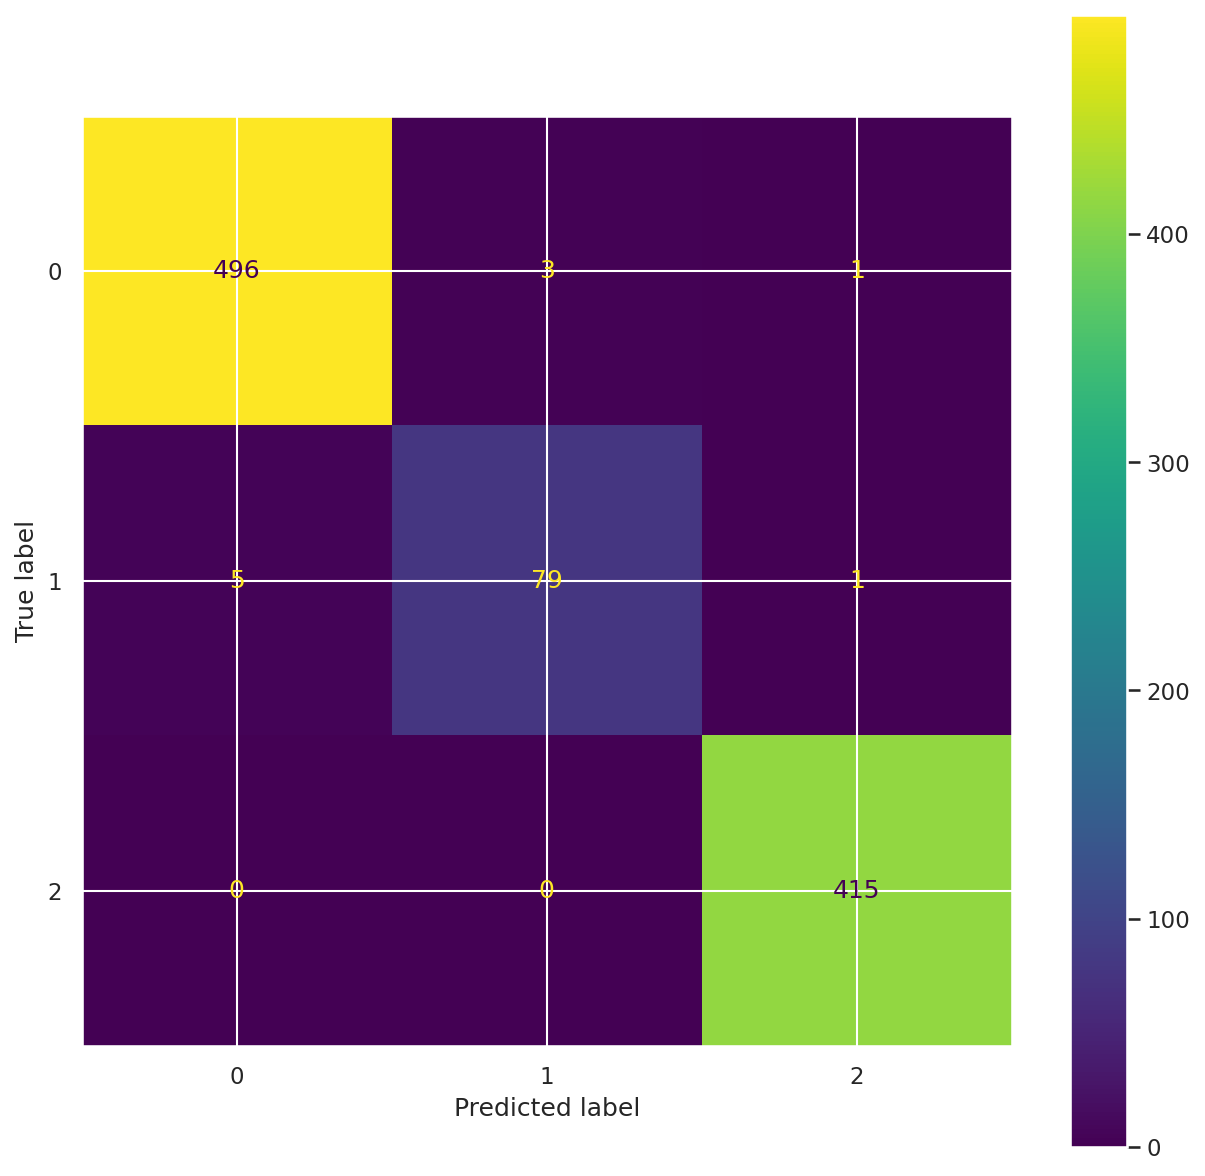

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_grid.classes_)
disp.plot()
plt.show()

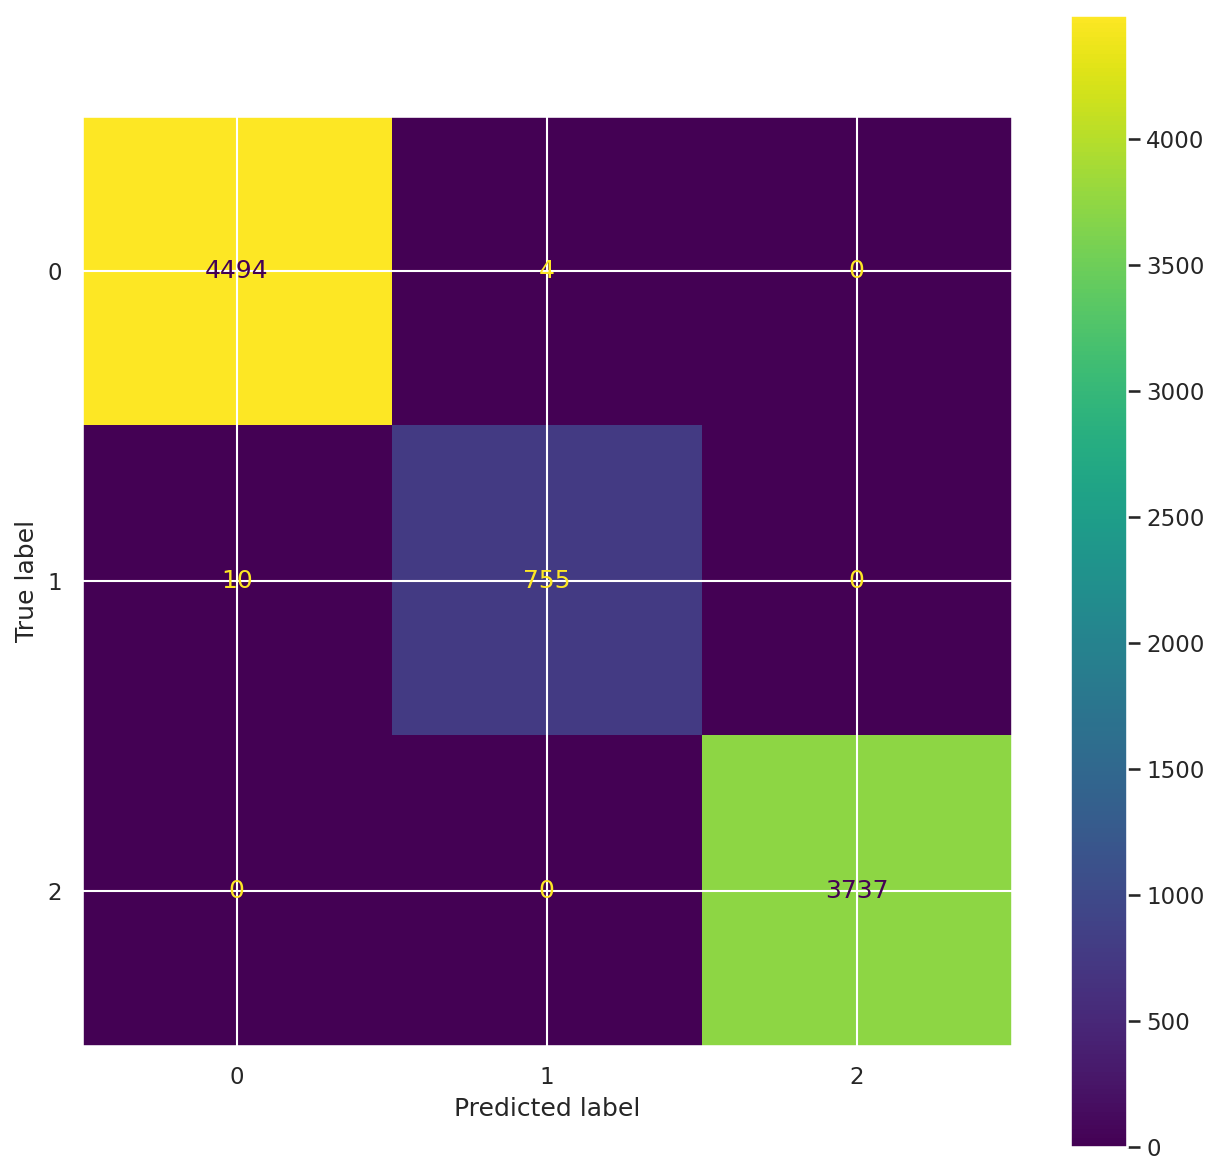

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_train_pred_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_grid.classes_)
disp.plot()
plt.show()